<a href="https://colab.research.google.com/github/oixchi/mathesis/blob/main/cleanup_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def gather_all_ebrains_links(base_url):
    # Function to gather and return all unique links from a base URL and its linked pages
    def get_ebrains_links(url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links = soup.find_all('a', href=True)

        # Use list comprehension to filter and process links
        filtered_links = [urljoin(url, link['href']) for link in all_links if 'ebrains.eu' in urljoin(url, link['href'])]
        unique_links = sorted(list(set(filtered_links)))
        return unique_links

    ebrains_links = get_ebrains_links(base_url)
    all_links = set(ebrains_links)

    for link in ebrains_links:
        page_links = get_ebrains_links(link)
        all_links.update(page_links)

    return sorted(list(all_links))

# Call the function and print the results
base_url = 'https://www.ebrains.eu/'
all_ebrains_links = gather_all_ebrains_links(base_url)
all_ebrains_links_without_pdf = [link for link in all_ebrains_links if not link.endswith('.pdf') and '@' not in link]
all_ebrains_links_with_pdf = [link for link in all_ebrains_links if link.endswith('.pdf')]

print(len(all_ebrains_links_without_pdf))
print(len(all_ebrains_links_with_pdf))

for link in all_ebrains_links_without_pdf:
  print(link)
print("---------------")
for link in all_ebrains_links_with_pdf:
  print(link)

In [ ]:
import requests
from bs4 import BeautifulSoup

def scrape_website(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        for tag in soup.find_all(['p', 'div', 'h1', 'h2', 'h3']):
            if tag.name == 'div':
                for p_tag in tag.find_all('p'):
                    text = p_tag.get_text().strip()
                    if text:  # Check if the line is not empty
                        if not text.endswith('.') and not text.endswith(':'):
                            text += '.' # make sentences out of the extracted information
                        print(text)
            else:
              text = tag.get_text().strip()
              if text:  # Check if the line is not empty
                  if not text.endswith('.') and not text.endswith(':'):
                      text += '.'
                  print(text)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

url_to_scrape = "https://www.ebrains.eu/projects"
scrape_website(url_to_scrape)


In [28]:
from google.colab import files
import os

uploaded = files.upload()

print("Files in current directory:")
print(os.listdir())

Saving dataset_some_processing.txt to dataset_some_processing.txt
Files in current directory:
['.config', 'chunks_dataset.txt', 'dataset_some_processing.txt', 'sample_data']


In [ ]:
!pip install pymupdf

import requests
import fitz  # pymupdf
import io
from bs4 import BeautifulSoup

def read_urls_from_file(file_path):
    # Reads all URLS from the subset_ebrains_links.txt
    with open(file_path, 'r', encoding='utf-8') as file:
        urls = file.readlines()
    return [url.strip() for url in urls]  # Remove any leading/trailing whitespace or newline characters

def extract_text_from_pdf(pdf_url, txt_file):
    try:
        # Download the PDF into memory
        response = requests.get(pdf_url)
        if response.status_code == 200:
            pdf_data = io.BytesIO(response.content)
            document = fitz.open(stream=pdf_data, filetype="pdf")  # Open directly from the BytesIO object
        else:
            print(f"Failed to download PDF from {pdf_url}. Status code: {response.status_code}")
            return

        # Iterate over each page in the PDF and extract the text
        full_text = ""
        for page_num in range(document.page_count):
            page = document.load_page(page_num)  # Load each page separately
            text = page.get_text()  # Extract text from the current page

            if text:  # Ensure there's text on the page
                # Ensure the text ends with a dot
                if not text.endswith(('.', ':')):
                    text += '.'

                # Remove line breaks, then add line breaks after every dot
                text = text.replace("\n", " ")  # Remove unwanted line breaks
                text = text.replace(". ", ".\n")  # Replace each dot followed by space with a dot and line break

                full_text += text

        document.close()

        # Append the cleaned-up text to the txt file
        with open(txt_file, "a", encoding="utf-8") as file:
            file.write(full_text + "\n")

        print(f"Text extracted and appended successfully to '{txt_file}' from PDF: {pdf_url}")

    except Exception as e:
        print(f"An error occurred: {e}")

def scrape_ebrains_links_and_extract_text(urls_file, output_txt_file):
    # Scrapes URLs for content and extracts text
    urls = read_urls_from_file(urls_file)

    for url in urls:
        try:
            if url.startswith("https://files."):  # If it's a PDF file
                print(f"Extracting text from PDF: {url}")
                extract_text_from_pdf(url, output_txt_file)
            else:
                print(f"Scraping URL: {url}")
                response = requests.get(url)

                if response.status_code != 200:
                    print(f"Failed to retrieve {url}. Status code: {response.status_code}")
                    continue

                # Parse the HTML content using BeautifulSoup
                soup = BeautifulSoup(response.text, 'html.parser')

                # Open the output text file in append mode
                with open(output_txt_file, "a", encoding="utf-8") as file:
                    for tag in soup.find_all(['p', 'div', 'h1', 'h2', 'h3']):
                        if tag.name == 'div':
                            for p_tag in tag.find_all('p'):
                                text = p_tag.get_text().strip()
                                if text:  # Check if the line is not empty
                                    if not text.endswith('.') and not text.endswith(':'):
                                        text += '.'
                                    file.write(text + "\n")
                        else:
                            text = tag.get_text().strip()
                            if text:  # Check if the line is not empty
                                if not text.endswith('.') and not text.endswith(':'):
                                    text += '.'
                                file.write(text + "\n")

        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

subset_ebrains_links = 'subset_ebrains_links.txt'
output_txt_file = 'dataset_no_processing.txt'

scrape_ebrains_links_and_extract_text(subset_ebrains_links, output_txt_file)


Scraping URL: https://www.ebrains.eu/
Scraping URL: https://www.ebrains.eu/about
Scraping URL: https://www.ebrains.eu/about#national-nodes
Scraping URL: https://www.ebrains.eu/about#roadmap
Scraping URL: https://www.ebrains.eu/about#vision
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/atlas-driven-analysis-resources
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/gene-expression-analysis-in-human-brain-atlas-regions
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/image-annotation-and-export-of-coordinate-points
Scraping URL: https://www.ebrains.eu/brain-atlases/analysis/labelled-features-analysis
Scraping URL: https://www.ebrains.eu/brain-atlases/apis
Scraping URL: https://www.ebrains.eu/brain-atlases/apis/http-api
Scraping URL: https://www.ebrains.eu/brain-atlases/apis/python-client
Scraping URL: https://www.ebrains.eu/brain-atlases/collaboratory-2
Scraping URL: https://www.ebrains.eu/bra

In [ ]:
files.download('dataset_no_processing.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import time

start_time = time.time()
print(f"Function call started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")

end_time = time.time()
print(f"Function call ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60

print(f"Total time taken: {elapsed_time:.2f} seconds ({elapsed_minutes:.2f} minutes)")

Function call started at: 2025-02-16 18:43:40
Function call ended at: 2025-02-16 18:43:40
Total time taken: 0.00 seconds (0.00 minutes)


In [ ]:
!pip install faiss-cpu
!pip install sentence_transformers

In [37]:
import re
import numpy as np
import matplotlib.pyplot as plt

with open("chunks_dataset.txt", "r", encoding="utf-8") as file:
#with open("dataset_some_processing.txt", "r", encoding="utf-8") as file:
  text = file.read()

def split_text_into_chunks(text, max_words):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []
    current_length = 0
    for sentence in sentences:
        words = sentence.split()
        if current_length + len(words) > max_words:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0
        current_chunk.append(sentence)
        current_length += len(words)
    chunks.append(" ".join(current_chunk))
    return chunks

def split_text_into_chunks_with_overlap(text, max_words, overlap_words):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []
    current_word_count = 0

    for sentence in sentences:
        sentence_word_count = len(sentence.split())

        # Check if adding this sentence would exceed max_words
        if current_word_count + sentence_word_count <= max_words:
            current_chunk.append(sentence)
            current_word_count += sentence_word_count
        else:
            if current_chunk:
                # Append the current chunk before starting a new one
                chunks.append(" ".join(current_chunk))

                # Calculate overlap and create a new chunk with overlapping words
                overlap_sentences = " ".join(current_chunk[-overlap_words:]) if overlap_words < len(current_chunk) else " ".join(current_chunk)
                current_chunk = overlap_sentences.split()  # Start new chunk with overlapping content

                # Reset word count based on the new chunk
                current_word_count = len(current_chunk)

            # Add the current sentence to the new chunk
            current_chunk.append(sentence)
            current_word_count += sentence_word_count

    # Append any remaining content as a final chunk
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

def split_text_into_chunks_using_sentences(text):
    sentences = re.split(r'(?<=[.!?])', text)
    # Remove empty strings and return each sentence as a separate chunk
    return [sentence.strip() for sentence in sentences if sentence.strip()]


max_words=50
overlap_words=0
if overlap_words == 0:
  print("No overlap")
  # chunks = split_text_into_chunks(text, max_words)
else:
  print("Overlap")
  #chunks = split_text_into_chunks_with_overlap(text, max_words,overlap_words)

chunks = split_text_into_chunks_using_sentences(text)
print(len(chunks))

'''
x_values = list(range(1, len(chunks) + 1))
words_in_chunks = [len(chunk.split()) for chunk in chunks]
print(x_values)
print(words_in_chunks)

data = list(zip(x_values, words_in_chunks))

# Separate the x and y values
x_values = [item[0] for item in data]
y_values = [item[1] for item in data]

# Create the bar chart
plt.figure(figsize=(10, 15))
plt.bar(x_values, y_values, color='#DDF2D1', edgecolor='#CDEBC5')

# Customize the chart
plt.xlabel("chunk")
plt.ylabel("Number of words in chunk")
plt.xticks(x_values)
plt.yticks(words_in_chunks)
plt.grid(axis='y', linestyle='--', alpha=0.2)

plt.show()
'''


No overlap
34


'\nx_values = list(range(1, len(chunks) + 1))\nwords_in_chunks = [len(chunk.split()) for chunk in chunks]\nprint(x_values)\nprint(words_in_chunks)\n\ndata = list(zip(x_values, words_in_chunks))\n\n# Separate the x and y values\nx_values = [item[0] for item in data]\ny_values = [item[1] for item in data]\n\n# Create the bar chart\nplt.figure(figsize=(10, 15))\nplt.bar(x_values, y_values, color=\'#DDF2D1\', edgecolor=\'#CDEBC5\')\n\n# Customize the chart\nplt.xlabel("chunk")\nplt.ylabel("Number of words in chunk")\nplt.xticks(x_values)\nplt.yticks(words_in_chunks)\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.2)\n\nplt.show()\n'

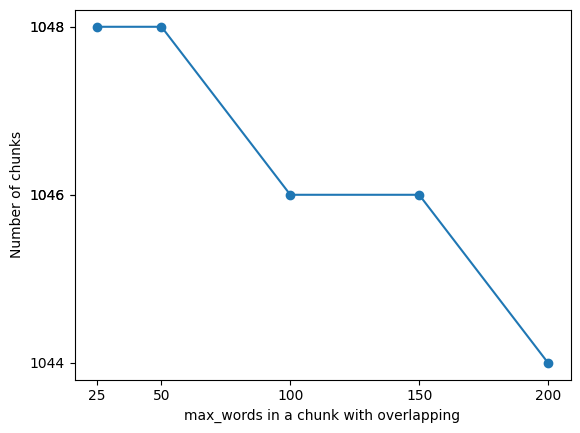

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x = [25, 50, 100, 150, 200]
y = [1048, 1048, 1046, 1046, 1044]

# Create the plot
plt.plot(x, y, marker='o', linestyle='-')

# Add labels
plt.xlabel("max_words in a chunk with overlapping")
plt.ylabel("Number of chunks")
#plt.title("Test")

# Set ticks for x and y axes to show only the specific values
plt.xticks(x)
plt.yticks(y)

# Show the plot
plt.show()


In [40]:
from sentence_transformers import SentenceTransformer
import faiss

max_words=50
overlap_words=0
'''
if overlap_words == 0:
  print("No overlap")
  chunks = split_text_into_chunks(text, max_words)
else:
  print("Overlap")
  chunks = split_text_into_chunks_with_overlap(text, max_words,overlap_words)
'''
chunks = split_text_into_chunks_using_sentences(text)
print(len(chunks))
model1 = SentenceTransformer('all-MiniLM-L6-v2')
#model1 = SentenceTransformer('paraphrase-MPNet-base-v2')
#model1 = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)
# Encode the chunks into embeddings
chunk_embeddings = model1.encode(chunks)


# Create a FAISS index
embedding_dimension = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dimension)
index.add(np.array(chunk_embeddings))

# Retrieve all vectors from the FAISS index
stored_vectors = index.reconstruct_n(0, index.ntotal)
# print(stored_vectors[0])


def retrieve_relevant_chunks(query, index, chunks, model, top_k):
    query_embedding = model1.encode([query])
    distances, indices = index.search(query_embedding, top_k)
    return [chunks[idx] for idx in indices[0]]

query = "What is the purpose of the MEBRAINS Template in neuroimaging studies?"
top_k = 1
relevant_chunks = retrieve_relevant_chunks(query, index, chunks, model1, top_k)

# Format retrieved chunks as context
context = " ".join(relevant_chunks)
num_words_in_context = len(context.split())

# Prepare input text with relevant context and query as before
# input_text = f"Chosen Model: {model1}\nMax words in chunk: {max_words}\nOverlap words: {overlap_words}\nValue of k: {top_k}\nQuestion: {query}\nWords in context: {num_words_in_context}\nRetrieven context: {context}\n"
input_text = f"Chosen Model: {model1}\nValue of k: {top_k}\nQuestion: {query}\nWords in context: {num_words_in_context}\nRetrieven context: {context}\n"
print(input_text)


34
Chosen Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
Value of k: 1
Question: What is the purpose of the MEBRAINS Template in neuroimaging studies?
Words in context: 45
Retrieven context: The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals.



In [41]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `llama2` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `llama2`


In [48]:
print(query)
print("-----------")
print(context)
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer_llm_3 = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-3B')
model_llm_3 = AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.2-3B')
model_llm_3.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_llm_3.to(device)

def generate_llama3_dynamically(query):

    length_factor=1.2
    max_cap=1024
    input_text = (query + "\n" + context).strip()

    # Tokenize and generate text
    inputs = tokenizer_llm_3(input_text, return_tensors="pt")
    input_length = inputs['input_ids'].shape[1]
    max_length = min(input_length * length_factor, max_cap)
    outputs = model_llm_3.generate(**inputs, max_length=max_length)

    # Decode and return the generated output
    return tokenizer_llm_3.decode(outputs[0], skip_special_tokens=True)

def generate_llama3(query):

    # Combine context and query
    input_text = query + "\n" + context
    # input_text = (context + "\n" + query).strip()

    # Tokenize and generate text
    inputs = tokenizer_llm_3(input_text, return_tensors="pt")
    input_length = inputs['input_ids'].shape[1]
    outputs = model_llm_3.generate(**inputs, max_length=100)

    # Decode and return the generated output
    return tokenizer_llm_3.decode(outputs[0], skip_special_tokens=True)

llama3_llm_response = generate_llama3(query)
print(llama3_llm_response)

What is the purpose of the MEBRAINS Template in neuroimaging studies?
-----------
The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


What is the purpose of the MEBRAINS Template in neuroimaging studies?
The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals. The MEBRAINS Template is based on a probabilistic cytoarchitectonic atlas


In [49]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

ground_truth = "The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals."

ollama_response = "The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals. The MEBRAINS Template is based on a probabilistic cytoarchitectonic atlas"


# Tokenize the sentences into words
reference_tokens = [ground_truth.lower().split()]
candidate_tokens = ollama_response.lower().split()

# Compute BLEU score
smoothing = SmoothingFunction().method1
bleu_score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing)

print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.8130


In [ ]:
pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# Example: Single question and answer
ground_truth = "The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals."
# Ground truth (reference)
ollama_response = "What is the purpose of the MEBRAINS Template in neuroimaging studies? It includes detailed information about the organization of the monkey brain at multiple levels, ranging from the microscopic level to the macroscopic level of the entire brain. The multilevel macaque brain builds on the MEBRAINS Template, a nonlinear symmetric population-based monkey template which reflects the macroanatomical scale as a unifying principle of organization. The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals. MEBRAINS Cytoarchitectonic Maps are complemented with information on the densities of 14 different receptors for multiple classical neurotransmitters, representing a mesoscopical scale of brain organisation."
# Ollama3 response

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE score
scores = scorer.score(ground_truth, ollama_response)

# Print individual scores
print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f}")
print(f"ROUGE-2: {scores['rouge2'].fmeasure:.4f}")
print(f"ROUGE-L: {scores['rougeL'].fmeasure:.4f}")

ROUGE-1: 0.5055
ROUGE-2: 0.5000
ROUGE-L: 0.5055


In [ ]:
from rouge_score import rouge_scorer

# Example: Single question and answer
ground_truth = "The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals."
# Ground truth (reference)
ollama_response = "What is the purpose of the MEBRAINS Template in neuroimaging studies? It includes detailed information about the organization of the monkey brain at multiple levels, ranging from the microscopic level to the macroscopic level of the entire brain. The multilevel macaque brain builds on the MEBRAINS Template, a nonlinear symmetric population-based monkey template which reflects the macroanatomical scale as a unifying principle of organization. The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals. MEBRAINS Cytoarchitectonic Maps are complemented with information on the densities of 14 different receptors for multiple classical neurotransmitters, representing a mesoscopical scale of brain organisation."
# Ollama3 response

# Initialize ROUGE scorer (ROUGE-1 measures word overlap)
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
scores = scorer.score(ground_truth, ollama_response)

# Extract precision, recall, and compute F1
precision = scores['rouge1'].precision
recall = scores['rouge1'].recall
f1_score = scores['rouge1'].fmeasure

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.3382
Recall: 1.0000
F1 Score: 0.5055


In [51]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

ground_truth = "The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals."

generated_response = "It includes detailed information about the organization of the monkey brain at multiple levels, ranging from the microscopic level to the macroscopic level of the entire brain. The multilevel macaque brain builds on the MEBRAINS Template, a nonlinear symmetric population-based monkey template which reflects the macroanatomical scale as a unifying principle of organization. The MEBRAINS Template can be used for the analysis of functional imaging and whole-brain connectivity studies, and also serves as anchorage for the MEBRAINS Cytoarchitectonic Maps, which are defined at the microscopic scale and constitute reference volumes of interest for anatomical assignment of neuroimaging signals. MEBRAINS Cytoarchitectonic Maps are complemented with information on the densities of 14 different receptors for multiple classical neurotransmitters, representing a mesoscopical scale of brain organisation."
# Encode the sentences into embeddings
embedding_ground_truth = model.encode(ground_truth)
embedding_generated = model.encode(generated_response)

# Compute the cosine similarity between the embeddings
similarity = cosine_similarity([embedding_ground_truth], [embedding_generated])

print(f"Cosine Similarity: {similarity[0][0]:.4f}")


Cosine Similarity: 0.8658
